# Network visualization

Last updated: 08182023  
By: Lauren Liao  
Purpose: from top word similarity matrix 

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

%matplotlib inline

**Data loading**  
the data starts with the preprocessed text (pickled) file with top 10 variables and top 30 variables

In [8]:
# read processed text from previous
top10_lst =  pd.read_pickle("../results/top10_mean.pkl")
top30_lst =  pd.read_pickle("../results/top30_mean.pkl")

## Visualize top 10 for network

1. specifying all nodes
2. find the duplication
3. plot all connections and label KEYTERMS and connection words (duplicated)

In [3]:
all_nodes = [item for sublist in [[x[0]] for x in top10_lst] + 
             [[k for k in x[1].keys()] for x in top10_lst] for item in sublist]

In [4]:
duplicated_words = [word for word, count in Counter(all_nodes).items() if count > 1]
# duplicated_words

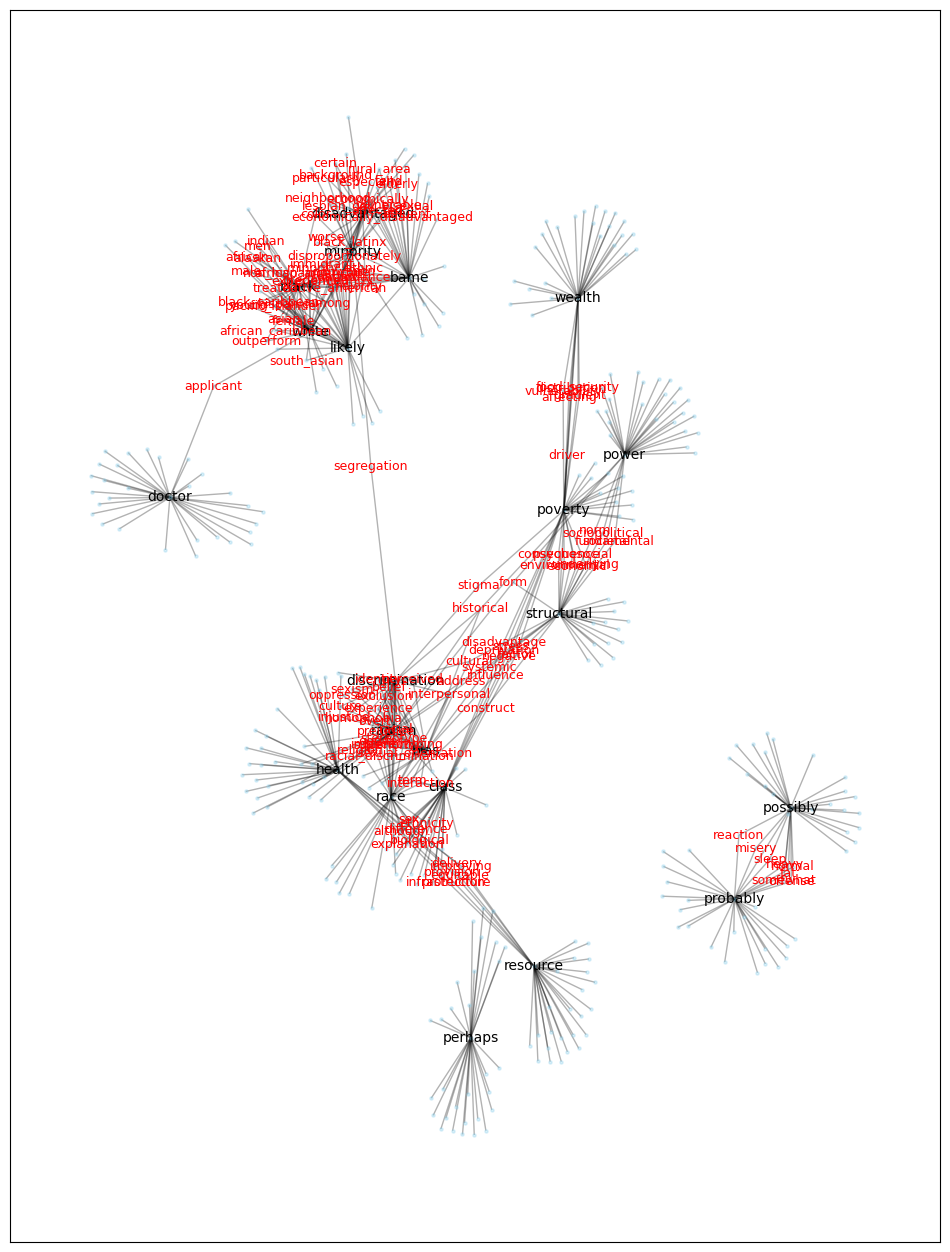

In [5]:
np.random.seed(1234567891)

# create an empty graph
G = nx.Graph()

# adding nodes
G.add_nodes_from(all_nodes)

# adding edges
for word_lst in top10_lst:
    word, word_related_dict = word_lst
    for related_word, weight in word_related_dict.items():
        G.add_edge(word, related_word, weight=weight*0.1)

plt.figure(figsize=(12, 16))
pos_layout = nx.spring_layout(G)
# Manual tweaking to limit node label overlap in the visualization
# pos_layout["discrimination"] += (0.1, -0.10)
pos_layout["bias"] += (0.03, -0.06)
pos_layout["racism"] += (0.05, -0.03)
pos_layout["bame"] += (0.05, -0.05)
pos_layout["white"] += (0.05, -0.05)
pos_layout["likely"] += (0.05, -0.05)
pos_layout["neighborhood"] += (-0.05, -0.05)

nx.draw_networkx(G, pos_layout, with_labels=False, node_size=5, node_color='skyblue', alpha=0.3)
nodes_with_labels = [x[0] for x in top10_lst]  # specify the nodes for which you want to display labels
node_labels = {node: node for node in nodes_with_labels}
nx.draw_networkx_labels(G, pos=pos_layout, labels=node_labels, font_size=10)

# add additional red labels
additional_labels = set(duplicated_words) - set(node_labels.keys())
additional_label_colors = {node: node for node in additional_labels}
nx.draw_networkx_labels(G, pos=pos_layout, labels=additional_label_colors, font_size=9, font_color='red')


plt.show()

### Find connections of specific duplication words for top 30

leveraging the network to find (harder to visualize top 30)

In [9]:
all_nodes30 = [item for sublist in [[x[0]] for x in top30_lst] + 
               [[k for k in x[1].keys()] for x in top30_lst] for item in sublist]
duplicated_words30 = [word for word, count in Counter(all_nodes30).items() if count > 1]

In [10]:
np.random.seed(1234567891)

# create an empty graph
G = nx.Graph()

# adding nodes
G.add_nodes_from(all_nodes30)

# adding edges
for word_lst in top30_lst:
    word, word_related_dict = word_lst
    for related_word, weight in word_related_dict.items():
        G.add_edge(word, related_word, weight=weight*0.1)

In [16]:
[print(f"'{connect_word}': {list(G.neighbors(connect_word))}") 
 for connect_word in set(duplicated_words30) - set(node_labels.keys()) if len(list(G.neighbors(connect_word))) > 3];

'historical': ['racism', 'discrimination', 'power', 'bias']
'superiority': ['race', 'racism', 'discrimination', 'bias']
'black_latinx': ['bame', 'minority', 'disadvantaged', 'likely']
'predominantly': ['black', 'white', 'bame', 'likely']
'latino': ['black', 'white', 'bame', 'minority', 'disadvantaged', 'likely']
'nonwhite': ['black', 'white', 'bame', 'minority', 'disadvantaged', 'likely']
'african_american': ['black', 'white', 'minority', 'likely']
'implicit': ['race', 'racism', 'discrimination', 'bias']
'prejudice': ['race', 'racism', 'discrimination', 'bias']
'experienced': ['black', 'white', 'minority', 'likely']
'minority_ethnic': ['black', 'white', 'bame', 'minority', 'disadvantaged', 'likely']
'interpersonal': ['race', 'racism', 'discrimination', 'bias', 'structural']
'racial': ['race', 'racism', 'discrimination', 'bias']
'native_american': ['black', 'white', 'bame', 'minority', 'likely']
'sexual_orientation': ['class', 'race', 'discrimination', 'bias']
'stereotype': ['race', 'ra